### Imports

In [2]:
%matplotlib widget

import argparse
import copy
import os
import logging
import secrets
import numpy
import copy
import gc
import math
from datetime import timedelta
# import mplcursors

from ipywidgets import IntProgress
# from IPython.display import display
# from IPython.display import Audio
from IPython import display

import time

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from complexPyTorch.complexFunctions import complex_relu

import auraloss

# Audio
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from torio.io import CodecConfig

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms
import torchvision.models as TVM

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

print(torch.__version__)
print(torchaudio.__version__)


2.3.0+cu121
2.3.0+cu121


### Configuration

In [3]:
base_dataset_directory = '/home/jacob/noisy-commonvoice-24k/en/clear'
noisy_dataset_directory = '/home/jacob/noisy-commonvoice-24k/en/noisy'
models_dir = '/home/jacob/denoise-models'

### Load datasets

In [4]:
common_voice_dataset = torchaudio.datasets.COMMONVOICE(root=base_dataset_directory)
common_voice_noisy_dataset = torchaudio.datasets.COMMONVOICE(root=noisy_dataset_directory)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    

### Load datasets and create train / test splits. The same seed is used for splitting noisy and clear datasets so the files match up.

In [6]:
device="cuda"

loader_batch_size = 1
loader_num_workers = 4

split_generator_0 = torch.Generator().manual_seed(314)
noisy_train, noisy_test = random_split(common_voice_dataset, [0.9, 0.1], generator=split_generator_0)

split_generator_1 = torch.Generator().manual_seed(314)
clear_train, clear_test = random_split(common_voice_noisy_dataset, [0.9, 0.1], generator=split_generator_1)

def collate_fn(batch):
    # print(f"Collating batch size {len(batch)}")
    
    # Extract the tensors from the batch
    tensors = [item[0] for item in batch]
    tensors = [item.permute(1, 0) for item in tensors]
    
    # Pad the tensors to the same length
    padded_tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0)
    
    padded_tensors = [item.permute(1, 0) for item in padded_tensors]
        
    for i, tensor in enumerate(padded_tensors):
        batch[i] = tensor

    # print(f"Returning batch size {len(batch)}")

    return batch

clear_loader = DataLoader(
    noisy_train,
    batch_size=loader_batch_size,
    num_workers=loader_num_workers,
    pin_memory=True,
    pin_memory_device=device,
    # collate_fn=collate_fn,
)

noisy_loader = DataLoader(
    clear_train,
    batch_size=loader_batch_size,
    num_workers=loader_num_workers,
    pin_memory=True,
    pin_memory_device=device,
    # collate_fn=collate_fn,
)

# noisy_1 = next(iter(noisy_train))
# clear_1 = next(iter(clear_train))

# Audio(noisy_1[0].squeeze(), rate=48000)




In [ ]:
# Audio(clear_1[0].squeeze(), rate=48000)

In [8]:
### Create a model

sample_rate = 24000

sample_batch_ms = 400
hidden_size_ms = 600

samples_per_batch = int((sample_batch_ms / 1000) * sample_rate)
samples_per_hidden = int((hidden_size_ms / 1000) * sample_rate)

gc.collect()
torch.cuda.empty_cache()

class ComplexRelu(nn.Module):
    def __init__(self):
        super(ComplexRelu, self).__init__()
             
    def forward(self, x):
        x = complex_relu(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device, dtype):
        super(ConvBlock, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, device=device, dtype=dtype),
            nn.BatchNorm1d(num_features=out_channels, device=device, dtype=dtype),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, device=device, dtype=dtype),
            nn.BatchNorm1d(num_features=out_channels, device=device, dtype=dtype),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.sequential(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, device, dtype):
        super(Down, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.MaxPool1d(kernel_size=2, stride=2),
            ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype)
        )
        
    def forward(self, x):
        return self.sequential(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, device, dtype):
        super(Up, self).__init__()
        
        self.transpose = nn.ConvTranspose1d(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=2, stride=2, device=device, dtype=dtype)
        self.convBlock = ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype)
        
    def forward(self, x1, x2):        
        x1 = self.transpose(x1)
        
        diff = x2.size()[1] - x1.size()[1]  # Calculate difference correctly
        # print(f"Transposed x1: {x1.size()} x2: {x2.size()} diff: {diff}")
        
        # Pad x1 if necessary
        x1 = nnF.pad(x1, (diff // 2, diff - diff // 2))
        # print(f"Padded x1: {x1.size()}")
    
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        # print(f"Concatenated x: {x.size()}")
        
        x = self.convBlock(x)
        
        # print(f"ConvBlock output: \n{x.size()}")
        
        return x
    
class UpWithLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, layer_sizes, device, dtype):
        super(UpWithLSTM, self).__init__()
        
        lstm_input_size = samples_per_batch
        for i in range(len(layer_sizes) - 1):
            lstm_input_size = lstm_input_size // 2
        
        self.pre_lstm_reduction = nn.Conv1d(in_channels=in_channels, out_channels=lstm_input_size, kernel_size=2, stride=2, device=device, dtype=dtype)
        self.lstm = nn.LSTM(input_size=lstm_input_size // 2, hidden_size=lstm_input_size * 4, num_layers=1, batch_first=True, device=device, dtype=dtype)
        # self.lstm_channel_reduction = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, device=device, dtype=dtype)
        self.lstm_downsample = nn.Conv1d(in_channels=lstm_input_size, out_channels=lstm_input_size, kernel_size=2, stride=2, device=device, dtype=dtype)
        self.lstm_expansion = nn.Conv1d(in_channels=lstm_input_size, out_channels=out_channels, kernel_size=1, stride=1, device=device, dtype=dtype)
        
        self.transpose = nn.ConvTranspose1d(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=2, stride=2, device=device, dtype=dtype)
        self.convBlock = ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype)
        
    def forward(self, x1, x2):
        # print(f"UPPPPPP x1 size: {x1.size()} x2 size: {x2.size()} x3 size: {x3.size()}")
        
        # print(f"x1 before LSTM: {x1.size()}")
        lstm_out = self.pre_lstm_reduction(x1)
        # print(f"Pre-LSTM output: {lstm_out.size()}")
        lstm_out = self.lstm(lstm_out)[0]
        # print(f"LSTM output: {lstm_out.size()}")        
        # lstm_out = self.lstm_channel_reduction(lstm_out)
        # print(f"LSTM lstm_channel_reduction output: {lstm_out.size()}")
        lstm_out = self.lstm_downsample(lstm_out)
        # print(f"LSTM lstm_downsample output: {lstm_out.size()}")
        lstm_out = self.lstm_expansion(lstm_out)
        # print(f"LSTM lstm_expansion output: {lstm_out.size()}")
        
        x1 = self.transpose(x1)
                
        diff = x2.size()[1] - x1.size()[1]  # Calculate difference correctly
        # print(f"Transposed x1: {x1.size()} x2: {x2.size()} diff: {diff}")
        
        # Pad x1 if necessary
        x1 = nnF.pad(x1, (diff // 2, diff - diff // 2))
        # print(f"Padded x1: {x1.size()}")
        
        # print(f"x1: {x1}, lstm: {lstm_out}")        
        x1 = x1 + lstm_out
    
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        # print(f"Concatenated x: {x.size()}")
        
        
        x = self.convBlock(x)
        
        # print(f"ConvBlock output: \n{x.size()}")
        
        return x
    
class OutLayer(nn.Module):
    def __init__(self, in_channels, out_channels, device, dtype):
        super(OutLayer, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),
            ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype),            
        )
        
    def forward(self, x):
        return self.sequential(x)

class UNet1d(nn.Module):
    def __init__(self, in_channels, device, dtype):
        super(UNet1d, self).__init__()
        
        layer_sizes = [64, 128, 256, 512, 1024]
        
        self.first_layer = ConvBlock(in_channels=in_channels, out_channels=layer_sizes[0], device=device, dtype=dtype)
        
        self.down_layers = [
            Down(in_channels=layer_sizes[i], out_channels=layer_sizes[i+1], device=device, dtype=dtype)
            for i in range(len(layer_sizes) - 1)
        ]
        self.down_layers_module_list = nn.ModuleList(self.down_layers)
                            
        self.upWithLSTM = UpWithLSTM(in_channels=layer_sizes[-1], out_channels=layer_sizes[-2], layer_sizes=layer_sizes, device=device, dtype=dtype)
        self.remaining_up_layers = [
            Up(in_channels=layer_sizes[-(i+2)], out_channels=layer_sizes[-(i+3)], device=device, dtype=dtype)
            for i in range(len(layer_sizes) - 3)
        ]
        self.up_layers_module_list = nn.ModuleList(self.remaining_up_layers)
        
        self.last_layer = OutLayer(in_channels=layer_sizes[1], out_channels=in_channels, device=device, dtype=dtype)

    
    def forward(self, x):
        # x = x.unsqueeze(0)
        
        # print(f"Unsqueezed input: \n{x.size()}")     
        
        x = self.first_layer(x)
        
        # print(f"First layer output: \n{x}")

        # print(f"after first layer x: {x}")
        down_outputs = []
        for down_layer in self.down_layers:
            x = down_layer(x)
            # print(f"after down layer x: {x}")
            # print(f"Down layer output: \n{x.size()}")
            down_outputs.append(x)
            
        down_outputs_reversed = list(reversed(down_outputs))
                
        x = self.upWithLSTM(x, down_outputs_reversed[1])
        # print(f"after up with lstm x: {x.size()}")
        
        for (i, up_layer) in enumerate(self.remaining_up_layers):
            x = up_layer(x, down_outputs_reversed[i + 2])
            # print(f"after up layer x: {x}")
            # print(f"Up layer output: \n{x.size()}")
        
        x = self.last_layer(x)
        # print(f"after last layer x: {x}")

        # print(f"Last layer output: \n{x.size()}")
        
        x = x.squeeze(0).squeeze(0)
        # print(f"after squeeze x: {x}")
        
        # print(f"Squeezed output: \n{x.size()}")

        return x


with torch.cuda.device(0):
    torch.cuda.empty_cache()
    dtype=torch.float32

    model_dict_path = models_dir + "/model-20241202-094614"
    
    sequence_model = UNet1d(in_channels=1, device=device, dtype=dtype)
    # sequence_model.load_state_dict(torch.load(model_dict_path, weights_only=True))
    # sequence_model.eval()
    # loss_fn = nn.L1Loss()
    # loss_fn = auraloss.time.SNRLoss()
    # loss_fn = auraloss.freq.SumAndDifferenceSTFTLoss()
    loss_fn = auraloss.time.SISDRLoss()
    loss_fn_2 = nn.L1Loss()

    optimizer = torch.optim.SGD(params=sequence_model.parameters(), lr=0.01)

    print(sequence_model)
    


UNet1d(
  (first_layer): ConvBlock(
    (sequential): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down_layers_module_list): ModuleList(
    (0): Down(
      (sequential): Sequential(
        (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): ConvBlock(
          (sequential): Sequential(
            (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (4

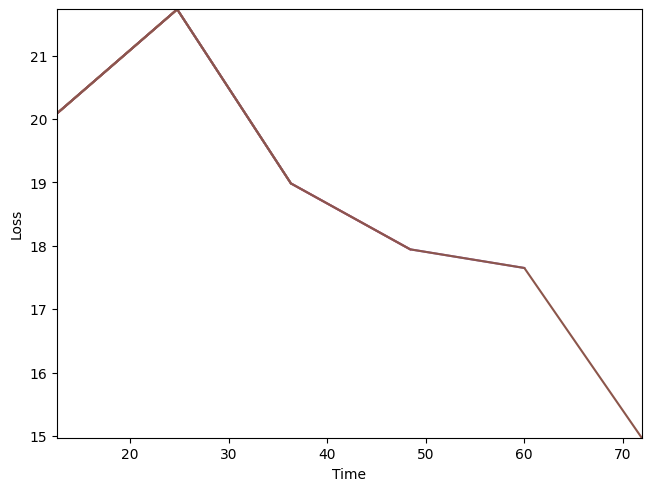

''

''

''

'elapsed: 0:01:11.928298 files_processed: 360 files_per_second: 5.0394453599632145'

''

"Last few epoch's loss averages: [20.087321043014526, 21.728394826253254, 18.9831968943278, 17.943613624572755, 17.649848047892252, 14.97302729288737]"

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ad6dc68b710>>
Traceback (most recent call last):
  File "/home/jacob/jupyter-venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
%%time

%matplotlib widget

### Train

files_processed = 0

t0 = time.time()

last_short_update_at = None

short_update = 150
long_update = 150
very_long_update = 3000

noisy_loader_iter = iter(noisy_loader)
clear_loader_iter = iter(clear_loader)
epoch_count = 0
files_processed_at_last_short_update = 0

custom_batching_size = 4

figdisplay = display.display("", display_id=True)
fig, axs = plt.subplots(1, 1, layout='constrained')
axs.set_xlabel('Time')
axs.set_ylabel('Loss')

# Add hover annotations
# cursor = mplcursors.cursor(axs, hover=True)
# cursor.connect("add", lambda sel: sel.annotation.set_text(f"Loss: {loss_numbers[sel.index]:.2f}\nTime: {loss_times[sel.index]:.2f}"))

loss_numbers = []
loss_numbers_short_update = []
loss_times = []

noisy_display = display.display("", display_id=True)
prediction_display = display.display("", display_id=True)
clear_display = display.display("", display_id=True)

status_string_display = display.display("", display_id=True)
last_save_status_string_display = display.display("", display_id=True)
last_few_loss_display = display.display("", display_id=True)

with torch.cuda.device(0):
    while(True):
        noisy_batch = [next(noisy_loader_iter)]
        clear_batch = [next(clear_loader_iter)]

        for i in range(custom_batching_size - 1):
            noisy_batch.append(next(noisy_loader_iter))
            clear_batch.append(next(clear_loader_iter))

        testing = [z[0].size() for z in noisy_batch]
        
        noisy = torch.cat([t[0].squeeze(0).squeeze(0) for t in noisy_batch], dim=0).to(device)
        clear = torch.cat([t[0].squeeze(0).squeeze(0) for t in clear_batch], dim=0).to(device)

        noisy_split = torch.split(noisy, samples_per_batch)
        clear_split = torch.split(clear, samples_per_batch)
        
        loss_sum = 0
        
        noisy_subsamples = []
        clear_subsamples = []
        
        noisy_split_len = len(noisy_split)
        for split_idx, noisy_subsample in enumerate(noisy_split):
            time1 = time.perf_counter()

            noisy_subsample = noisy_subsample.to(device)
            
            if split_idx == noisy_split_len - 1:
                noisy_pad = nn.ZeroPad1d((0, samples_per_batch - noisy_subsample.size()[0]))
                noisy_subsample = noisy_pad(noisy_subsample)
                
            noisy_subsamples.append(noisy_subsample)
            
            clear_subsample = clear_split[split_idx].to(device)

            if split_idx == noisy_split_len - 1:
                clear_pad = nn.ZeroPad1d((0, samples_per_batch - clear_subsample.size()[0]))
                clear_subsample = clear_pad(clear_subsample)
                
            clear_subsamples.append(clear_subsample)
            
        noisy_subsamples = torch.stack(noisy_subsamples).unsqueeze(1)
        clear_subsamples = torch.stack(clear_subsamples).unsqueeze(1)
        
        sequence_model.train()
        
        prediction = sequence_model(noisy_subsamples)
        
        loss = loss_fn(prediction, clear_subsamples)
        loss += loss_fn_2(prediction, clear_subsamples)
        loss_numbers_short_update.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        sequence_model.eval()

        if epoch_count % short_update == 0 and epoch_count != 0:
            now = time.time()
            elapsed_str = str(timedelta(seconds=now - t0))
            files_per_second = float(files_processed - files_processed_at_last_short_update) / (now - last_short_update_at if last_short_update_at else now - t0) 
            status_string_display.update(f"elapsed: {elapsed_str} files_processed: {files_processed} files_per_second: {files_per_second}")
            last_short_update_at = time.time()
            files_processed_at_last_short_update = files_processed
            
            elapsed_seconds = timedelta(seconds=now - t0).total_seconds()
            
            avg_loss = sum(loss_numbers_short_update) / len(loss_numbers_short_update)
            loss_numbers_short_update = []
            
            loss_times.append(elapsed_seconds)
            loss_numbers.append(avg_loss)
            
            # Plot loss data
            # todo: performant sliding window update lines?
            plt.plot(loss_times, loss_numbers)

            last_few_loss_avgs = loss_numbers[-10:]
            last_few_loss_display.update(f"Last few loss averages: {last_few_loss_avgs}")
            
            plt.autoscale(tight=True)

            figdisplay.update(fig)
            fig.canvas.draw()

        if epoch_count % long_update == 0 and epoch_count != 0:
            noisy_display.update(display.Audio(noisy.cpu().detach(), rate=sample_rate))
            prediction_reconstructed = prediction.view(25, -1).view(1, -1)
            prediction_display.update(display.Audio(prediction_reconstructed.cpu().detach(), rate=sample_rate))
            clear_display.update(display.Audio(clear.cpu().detach(), rate=sample_rate))

        if epoch_count % very_long_update == 0 and epoch_count != 0:
            model_save_path = models_dir + f"/model-{time.strftime("%Y%m%d-%H%M%S")}"
            last_save_status_string_display.update(f"Saving model to {model_save_path}")
            torch.save(sequence_model.state_dict(), model_save_path)

        epoch_count += 1
        files_processed += len(noisy_batch)

        del noisy, clear, noisy_split, clear_split, noisy_subsamples, clear_subsamples, noisy_batch, clear_batch
        
        gc.collect()
        torch.cuda.empty_cache()
        
